In [12]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pre_process import pre_process

Source of data https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide

In [13]:
data = pd.read_csv('./data/data.csv')
data.head()

,DateRep,NewConfCases,NewDeaths,CountryExp,Region
0,3/17/20,5,0,Afghanistan,AF
1,3/16/20,6,0,Afghanistan,AF
2,3/15/20,3,0,Afghanistan,AF
3,3/11/20,3,0,Afghanistan,AF
4,3/8/20,3,0,Afghanistan,AF


Source of population data https://data.worldbank.org/indicator/SP.POP.TOTL

In [14]:
"""
Adding population data to our data set. 
Some countries have different names, add aliases to this dictionary if necessary
"""

population = pd.read_csv('./data/population.csv')
population.head()


"""
Map countries that have different names in the datasets
"""
cmap = {
    "Cote dIvoire": "Cote d'Ivoire",
    "Czech republic": "Czech Republic",
    "Democratic Republic of the Congo": "Congo, Dem. Rep.",
    "Egypt": "Egypt, Arab Rep.",
    "Iran": 'Iran, Islamic Rep.',
    "Russia": "Russian Federation",
    "Slovakia": "Slovak Republic",
    "South Korea": "Korea, Rep.",
    "United States of America": "United States",
    "United kingdom": "United Kingdom",
    "Venezuela": "Venezuela, RB",
    "switzerland": "Switzerland"
}

p2018 = {r['Country Name']: r['2018'] for _, r in population.iterrows()}

data['CountryExp'] = data['CountryExp'].apply(lambda x: ' '.join(x.split('_')))
data['population'] = data['CountryExp'].apply(lambda c: p2018.get(cmap.get(c, c), 1) / 10 ** 6)

Outbreaks in each region / country occur on a different timeline.
If we want to compare them, we'll have to shift the graphs and establish a Day 0.

Currently you can use 3 different decision functions. Day 0 will be considered the first day when:

* `new_case_count`: At least threshold (default 5) number of cases occurred in a day..
* `total_case_count`: The total number of cases is larger or equal than threshold (default 100).
* `normalized_total_case_count`: The total number of cases per million people is at least threshold (default 2).

In [15]:
# Example: Day 0 is considered to be the first day when there were at least 20 new cases registered.

df = pre_process(data, 'new_case_count', threshold=20)
df[df.country == 'Romania'].head()

,country,new,total,days,new_deceased,total_deceased,increase,total_per_mil,new_per_mil,new_deceased_per_mil,total_deceased_per_mil,population,days_per_mil
313,Romania,20,45,0,0,0,80.000000,2.310781,1.027014,0.0,0.0,19.473936,0.000000
314,Romania,25,89,1,0,0,39.062500,4.570211,1.283767,0.0,0.0,19.473936,0.051351
315,Romania,24,113,2,0,0,26.966292,5.802628,1.232416,0.0,0.0,19.473936,0.102701
316,Romania,26,139,3,0,0,23.008850,7.137746,1.335118,0.0,0.0,19.473936,0.154052
317,Romania,45,184,4,0,0,32.374101,9.448526,2.310781,0.0,0.0,19.473936,0.205403


In [16]:
# Example: Day 0 is considered to be the first day when the total became 5 / million.

df = pre_process(data, 'normalized_total_case_count', threshold=5)
df[df.country == 'Spain'].head()

,country,new,total,days,new_deceased,total_deceased,increase,total_per_mil,new_per_mil,new_deceased_per_mil,total_deceased_per_mil,population,days_per_mil
563,Spain,61,261,0,2,3,30.500000,5.586024,1.305546,0.042805,0.064207,46.723749,0.000000
564,Spain,113,374,1,2,5,43.295019,8.004495,2.418470,0.042805,0.107012,46.723749,0.021402
565,Spain,56,430,2,0,5,14.973262,9.203029,1.198534,0.000000,0.107012,46.723749,0.042805
566,Spain,159,589,3,0,5,36.976744,12.606009,3.402980,0.000000,0.107012,46.723749,0.064207
567,Spain,615,1204,4,23,28,104.414261,25.768480,13.162471,0.492255,0.599267,46.723749,0.085610


In [17]:
def plot_countries(df, metric, *countries):
    """
    Plots a given metric for a provided list of countries.
    Possible metrics are: 
    
    'new' - number of new cases each day.
    'total' - total number of cases.
    'new_deceased' - number of deceased each day.
    'total_deceased' - total number of deceased.
    'total_per_mil' - total number of cases per million people.
    'increase' - increase in percentage compared to the previous day.
    'new_per_mil' - number of new cases per million people.
    'new_deceased_per_mil' - number of deceased each day per million people.
    'total_deceased_per_mil' - total number of deceased per million people
    """
    colors = list(matplotlib.colors.BASE_COLORS.keys())
    fig, ax = plt.subplots()
    
    for index, country in enumerate(countries):
        data = df[df.country == country]
        ax.plot(data.days, data[metric], label=country)
    
    fig.set_size_inches(18.5, 10.5)
    legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
    plt.show()

## Example 1

Visualize the total number of registered infections per million people in Italy, Germany, France, UK and Spain.
Day 0 is considered to be the day when the total number of cases per million first reached 2. 

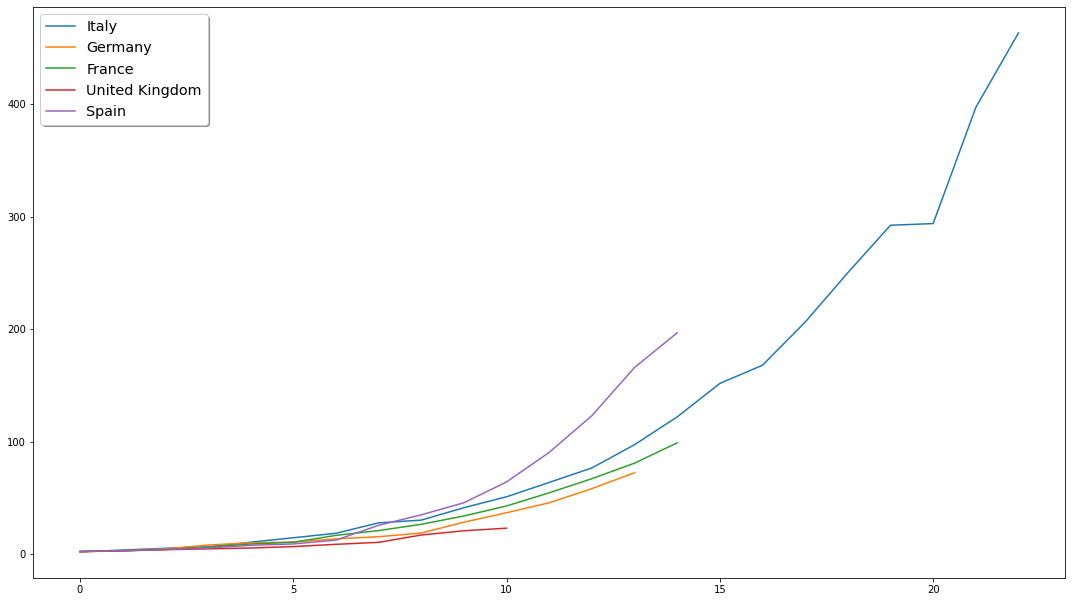

In [18]:
df = pre_process(data, 'normalized_total_case_count', threshold=2)
plot_countries(df, 'total_per_mil', 'Italy', 'Germany', 'France', 'United Kingdom', 'Spain')

## Example 2

Visualize the total number of deaths per million people in Italy and the US.
Day 0 is considered to be the day when the total number of cases per million reached 2. 

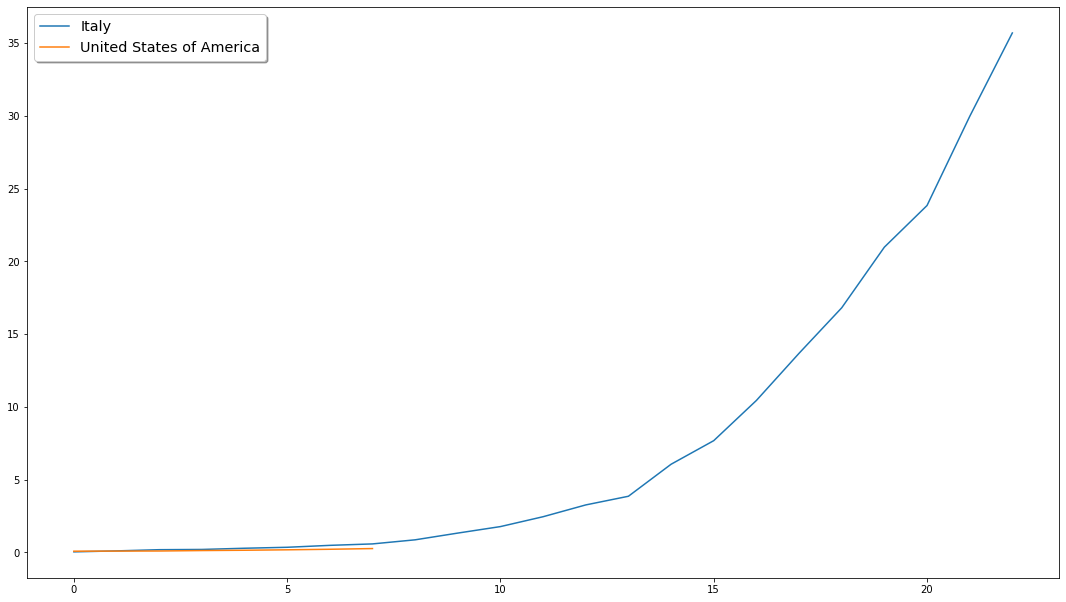

In [19]:
df = pre_process(data, 'normalized_total_case_count', threshold=2)
plot_countries(df, 'total_deceased_per_mil', 'Italy', 'United States of America')

## Example 3

Visualize the total number of cases per million people in Romania and Hungary.
Day 0 is considered to be the day when the first case appeared. 

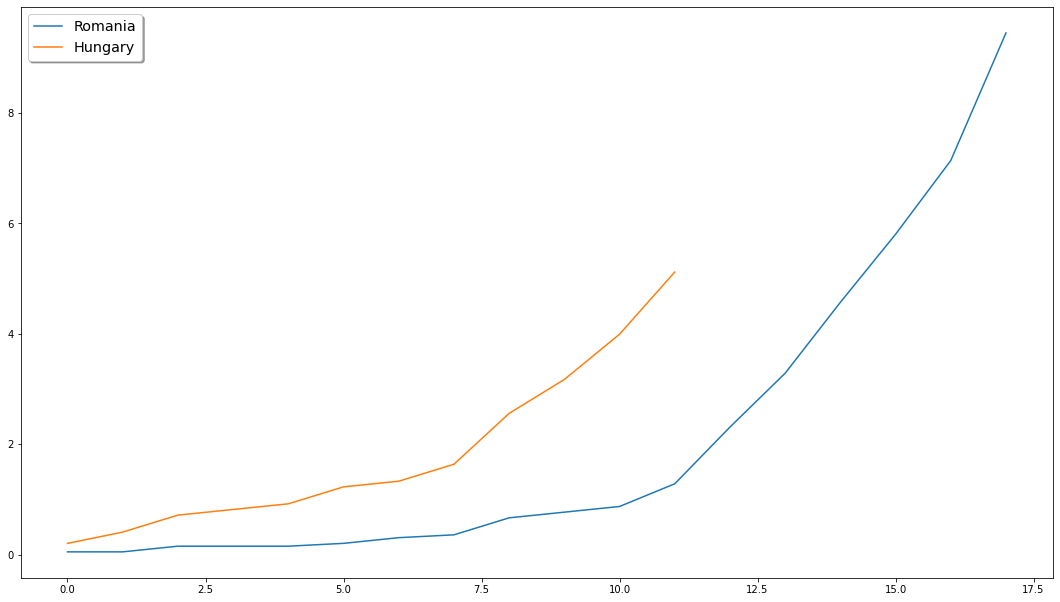

In [20]:
df = pre_process(data, 'total_case_count', threshold=1)
plot_countries(df, 'total_per_mil', 'Romania', 'Hungary')

## Example 4

Visualize increase for Italy, Spain, US, UK, Germany
Day 0 is considered to be the day when the total number of cases per million reached 2. 

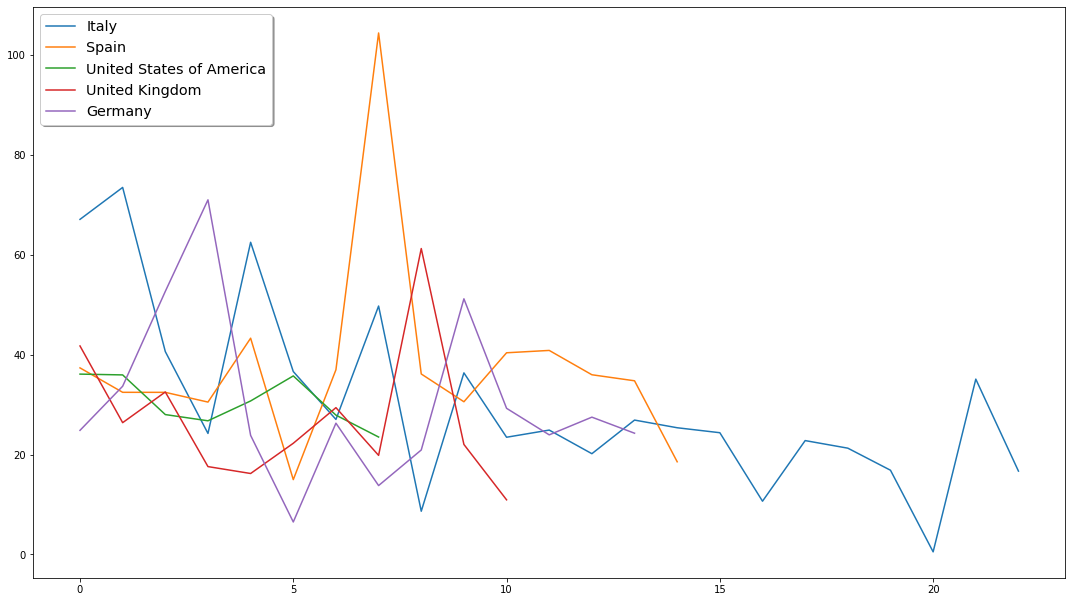

In [21]:
df = pre_process(data, 'normalized_total_case_count', threshold=2)
plot_countries(df, 'increase', 'Italy', 'Spain', 'United States of America', 'United Kingdom', 'Germany')

In [22]:
df[df.country == 'Italy']

,country,new,total,days,new_deceased,total_deceased,increase,total_per_mil,new_per_mil,new_deceased_per_mil,total_deceased_per_mil,population,days_per_mil
378,Italy,53,132,0,0,2,67.088608,2.184299,0.877029,0.000000,0.033095,60.431283,0.000000
379,Italy,97,229,1,4,6,73.484848,3.789428,1.605129,0.066191,0.099286,60.431283,0.016548
380,Italy,93,322,2,5,11,40.611354,5.328366,1.538938,0.082739,0.182025,60.431283,0.033095
381,Italy,78,400,3,1,12,24.223602,6.619088,1.290722,0.016548,0.198573,60.431283,0.049643
382,Italy,250,650,4,5,17,62.500000,10.756019,4.136930,0.082739,0.281311,60.431283,0.066191
383,Italy,238,888,5,4,21,36.615385,14.694376,3.938358,0.066191,0.347502,60.431283,0.082739
384,Italy,240,1128,6,8,29,27.027027,18.665829,3.971453,0.132382,0.479884,60.431283,0.099286
385,Italy,561,1689,7,6,35,49.734043,27.949100,9.283271,0.099286,0.579170,60.431283,0.115834
386,Italy,146,1835,8,17,52,8.644168,30.365068,2.415967,0.281311,0.860481,60.431283,0.132382
387,Italy,667,2502,9,28,80,36.348774,41.402397,11.037330,0.463336,1.323818,60.431283,0.148929
